# Workout Classification

This notebook used to train a model using [workout/exercise images](https://www.kaggle.com/datasets/hasyimabdillah/workoutexercises-images) dataset and then use the model to predict a random video from [workout/fitness video](https://www.kaggle.com/datasets/hasyimabdillah/workoutfitness-video) dataset.

## Necessary modules & packages

In [1]:
import os
import cv2
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from collections import deque
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Data Preprocessing

In [2]:
IMAGE_HEIGHT , IMAGE_WIDTH = 128, 128

DATA_DIR = "../input/workoutexercises-images"
CLASSES = os.listdir(DATA_DIR)

data = []
labels = []

for dirname, _, filenames in os.walk(DATA_DIR):
    data_class = dirname.split(os.path.sep)[-1]
    for filename in filenames:
        img_path = os.path.join(dirname, filename)
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMAGE_HEIGHT , IMAGE_WIDTH))
        
        data.append(image)
        labels.append(CLASSES.index(data_class))
        
data = np.array(data)
labels = np.array(labels)

labels = to_categorical(labels)

## Split & Augment Data

In [17]:
features_train, features_test, labels_train, labels_test = train_test_split(data, 
                                                                            labels,
                                                                            test_size = 0.1,
                                                                            shuffle = True,
                                                                            random_state=42
                                                                           )

In [18]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
    rescale = 1./255,
#     rotation_range = 30,
#     zoom_range = 0.15,
#     width_shift_range = 0.2,
#     height_shift_range = 0.2,
#     shear_range = 0.15,
    horizontal_flip = True,
    fill_mode = "nearest"
)

trainAug.fit(features_train)

# initialize the validation/testing data augmentation object
valAug = ImageDataGenerator(rescale = 1./255)

valAug.fit(features_test)

## Create, Compile, Train, and Evaluate Model

In [72]:
def create_model():
    model = tf.keras.models.Sequential()
    
    # Convolution layers
    model.add(tf.keras.layers.Conv2D(filters = 32,
                                     kernel_size = (3, 3),
                                     activation = 'relu',
                                     input_shape = (IMAGE_HEIGHT , IMAGE_WIDTH, 3)))
    model.add(tf.keras.layers.MaxPool2D((2,2)))
    
#     model.add(tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'))
#     model.add(tf.keras.layers.MaxPool2D((2,2)))
    
#     model.add(tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'))
#     model.add(tf.keras.layers.MaxPool2D((2,2)))
    
#     model.add(tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'))
#     model.add(tf.keras.layers.MaxPool2D((2,2)))
    
#     model.add(tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'))
#     model.add(tf.keras.layers.MaxPool2D((2,2)))
    
    # Hidden layers
    model.add(tf.keras.layers.Flatten())
#     model.add(tf.keras.layers.Dense(128, activation = 'relu'))
    model.add(tf.keras.layers.Dense(256, activation = 'relu'))
    model.add(tf.keras.layers.Dense(512, activation = 'relu'))
    model.add(tf.keras.layers.Dense(256, activation = 'relu'))
    model.add(tf.keras.layers.Dense(512, activation = 'relu'))
    model.add(tf.keras.layers.Dense(256, activation = 'relu'))
    model.add(tf.keras.layers.Dense(128, activation = 'relu'))
    model.add(tf.keras.layers.Dense(64, activation = 'relu'))
    model.add(tf.keras.layers.Dense(len(CLASSES), activation = 'softmax'))
    
    model.summary()
    
    return model

In [73]:
# Construct the model
workout_model = create_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 127008)            0         
_________________________________________________________________
dense_88 (Dense)             (None, 256)               32514304  
_________________________________________________________________
dense_89 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_90 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_91 (Dense)             (None, 512)             

In [74]:
EPOCH = 1000

# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', 
                                        patience = 5, 
                                        mode = 'min', 
                                        restore_best_weights = True)

# compile our model (this needs to be done after our setting our layers to being non-trainable)
opt = tf.keras.optimizers.Adam()

workout_model.compile(loss = 'categorical_crossentropy',
              optimizer = opt,
              metrics = ['acc']
             )
# train the head of the network for a few epochs (all other layers
# are frozen) -- this will allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random
model_history = workout_model.fit(trainAug.flow(features_train, y = labels_train),
                                  epochs = EPOCH,
                                  batch_size = 128,
                                  validation_data = valAug.flow(features_test, labels_test),
                                  shuffle = True,
                                  callbacks = [early_stopping_callback]
                                 )

Epoch 1/1000
57/57 [==============================] - 12s 190ms/step - loss: 1.9572 - acc: 0.2896 - val_loss: 1.2194 - val_acc: 0.5419
Epoch 2/1000
57/57 [==============================] - 11s 194ms/step - loss: 0.5320 - acc: 0.8247 - val_loss: 0.1788 - val_acc: 0.9409
Epoch 3/1000
57/57 [==============================] - 11s 188ms/step - loss: 0.0970 - acc: 0.9720 - val_loss: 0.0327 - val_acc: 0.9852
Epoch 4/1000
57/57 [==============================] - 11s 189ms/step - loss: 0.0878 - acc: 0.9753 - val_loss: 0.0647 - val_acc: 0.9852
Epoch 5/1000
57/57 [==============================] - 11s 195ms/step - loss: 0.0701 - acc: 0.9852 - val_loss: 0.0123 - val_acc: 0.9951
Epoch 6/1000
57/57 [==============================] - 11s 186ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 8.6041e-04 - val_acc: 1.0000
Epoch 7/1000
57/57 [==============================] - 11s 186ms/step - loss: 1.1393e-04 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 8/1000
57/57 [===========================

7/7 [==============================] - 0s 34ms/step - loss: 0.0000e+00 - acc: 1.0000


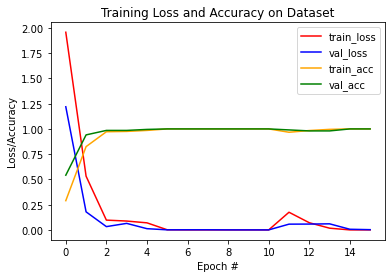

In [75]:
# evaluate the network
model_evaluation_history = workout_model.evaluate(features_test, labels_test)

# plot the training loss and accuracy
epoch = range(len(model_history.history["loss"]))
plt.figure()
plt.plot(epoch, model_history.history['loss'], 'red', label = 'train_loss')
plt.plot(epoch, model_history.history['val_loss'], 'blue', label = 'val_loss')
plt.plot(epoch, model_history.history['acc'], 'orange', label = 'train_acc')
plt.plot(epoch, model_history.history['val_acc'], 'green', label = 'val_acc')
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

## Test the Model on random video

Tricep Pushdown/tricep pushdown_35.mp4


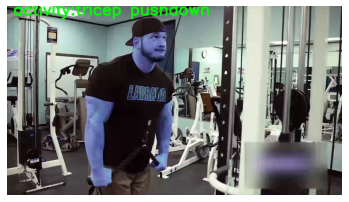

In [76]:
random_classes_names = random.choice(os.listdir('../input/workoutfitness-video/workout'))
random_file = random.choice(os.listdir(f'../input/workoutfitness-video/workout/{random_classes_names}'))
print(f'{random_classes_names}/{random_file}')

# Construct the input video file path
input_video_file_path = f'../input/workoutfitness-video/workout/{random_classes_names}/{random_file}'

# Initialize video input
video_capture = cv2.VideoCapture(input_video_file_path)
writer = None
H, W = None, None
Q = deque(maxlen=128)
n = 0

# Loop through each frame in the video
while True:
    # count the frame
    n += 1
    
    # read a frame
    success, frame = video_capture.read()
    
    # if frame not read properly then break the loop
    if not success:
        break
    
    # get frame dimensions
    if W is None or H is None:
        (H, W) = frame.shape[:2]
    
    # clone the frame for the output then preprocess the frame for the prediction
    output = frame.copy()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, (IMAGE_HEIGHT , IMAGE_WIDTH)).astype("float32")
        
    predictions = workout_model.predict(np.expand_dims(frame, axis=0))[0]
    Q.append(predictions)
    
    results = np.array(Q).mean(axis=0)
    i = np.argmax(results)
    label = CLASSES[i]
    
    text = 'activity:{}'.format(label)
    cv2.putText(output, text, (35, 50), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 10)
    
    if writer is None:
        fourcc = cv2.VideoWriter_fourcc(*"XVID")
        writer = cv2.VideoWriter('output.avi', fourcc, 30, (W, H), True)
        
    writer.write(output)
    
    plt.imshow(output)
    plt.axis('off')
    
    if i >= 0.99 and n >= 30:
        break
    
writer.release()
video_capture.release()

## Save the Model

In [77]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(workout_model)
tflite_model = converter.convert()

# Save the model.
with open('workout_model.tflite', 'wb') as f:
    f.write(tflite_model)

2022-05-25 10:39:41.695366: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-05-25 10:39:43.492419: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2022-05-25 10:39:43.492667: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-05-25 10:39:43.496335: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1137] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.012ms.
  function_optimizer: function_optimizer did nothing. time = 0.002ms.

2022-05-25 10:39:47.476804: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:351] Ignored output_format.
2022-05-25 10:39:47.476877: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:

## Reference:
https://pyimagesearch.com/2019/07/15/video-classification-with-keras-and-deep-learning/